In [64]:
from deap import base, creator, tools
from typing import Any, Callable
from tqdm import tqdm

import numpy as np
import random


In [65]:
rewards = np.array([ # x, y, reward
    [1, 5, 10],
    [4, 2, 15],
    [7, 8, 20],
    [3, 6, 25],
    [8, 3, 30],
    [2, 9, 35],
    [6, 7, 40],
    [9, 1, 45],
    [5, 4, 50],
    [7, 2, 55],
    [10, 5, 60],
    [12, 4, 65],
    [11, 7, 70],
    [14, 9, 75],
    [13, 3, 80],
    [9, 6, 85],
    [15, 8, 90],
    [16, 2, 95],
    [18, 5, 100],
    [20, 3, 105]
])

# grid_size = 10

# x_coords = np.arange(grid_size)
# y_coords = np.arange(grid_size)
# x, y = np.meshgrid(x_coords, y_coords)
# reward_values = np.random.randint(5, 100, size=(grid_size, grid_size))
# rewards = np.dstack((x, y, reward_values)).reshape(-1, 3)

n = rewards.shape[0]
POP_SIZE = 180
BUDGET = 20
N_GEN = 400
CX_PROB = 0.9
MUT_PROB = 0.3
MUT_DECAY_RATE = N_GEN / 100
MAX_DISTANCE = 4

In [ ]:
def init_individual(icls: Any, genes: Callable[[], np.ndarray]) -> list:
    individual = icls([genes(), genes()])
    return individual

def cx_individual(ind1: list, ind2: list) -> tuple:
    tools.cxPartialyMatched(ind1[0], ind2[0])
    tools.cxPartialyMatched(ind1[1], ind2[1])
    return ind1, ind2


def mut_individual(individual: list, indpb: float) -> tuple:
    path1, path2 = individual
    if np.random.random() < 0.5:
        tools.mutShuffleIndexes(path1, indpb=indpb)
    else:
        tools.mutShuffleIndexes(path2, indpb=indpb)
    return (individual,)


def eval_individual(individual: list) -> tuple:
    fitness = 0
    visited = set()

    for path in individual:
        total_distance = 0

        idx = path[0]
        prev_point = rewards[idx, :2]

        distance_to_first_point = np.linalg.norm(prev_point)
        if (total_distance + distance_to_first_point) > BUDGET:
            break
        total_distance += distance_to_first_point

        if not idx in visited:
            fitness += rewards[idx, 2]
            visited.add(idx)

        for i in range(len(path[1:])):
            idx = path[i]
            next_point = rewards[idx, :2]

            distance = np.linalg.norm(prev_point - next_point)
            if (total_distance + distance) > BUDGET:
                break
            total_distance += distance

            prev_point = next_point
            if not idx in visited:
                fitness += rewards[idx, 2]
                visited.add(idx)

    return (fitness,)


def calculate_mutation_probability(
    generation: int, max_generations: int, initial_prob: float, decay_rate: float
) -> float:
    return initial_prob * np.exp(-decay_rate * (generation / max_generations))


def penalize(eval_func: Callable) -> Callable:
    def wrapper(individual: list) -> tuple:
        fitness = eval_func(individual)[0]
        
        path1, path2 = individual
        idx1, idx2 = 0, 0

        point1 = rewards[path1[idx1], :2]
        point2 = rewards[path2[idx2], :2]

        distance1 = np.linalg.norm(point1)
        distance2 = np.linalg.norm(point2)

        while distance1 <= BUDGET or distance2 <= BUDGET:
            distance_between_agents = np.linalg.norm(point1 - point2)
            if distance_between_agents > MAX_DISTANCE:
                fitness = -10 * (rewards[path1[idx1], 2] + rewards[path2[idx2], 2])
            
            if distance1 <= BUDGET and idx1 < len(path1) - 1:
                idx1 += 1
            if distance2 <= BUDGET and idx2 < len(path2) - 1:
                idx2 += 1

            point1 = rewards[path1[idx1], :2]
            point2 = rewards[path2[idx2], :2]

            distance1 += np.linalg.norm(point1)
            distance2 += np.linalg.norm(point2)
        return (fitness,)

    return wrapper

In [67]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
toolbox.register("genes", np.random.permutation, n)
toolbox.register("individual", init_individual, creator.Individual, toolbox.genes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", cx_individual)
toolbox.register("mutate", mut_individual, indpb=MUT_PROB)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_individual)
# toolbox.decorate("evaluate", penalize)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()

In [68]:
ind = toolbox.individual()

toolbox.mutate(ind)

population = toolbox.population(n=POP_SIZE)
toolbox.evaluate(population[0])

(180,)

In [69]:
population = toolbox.population(n=POP_SIZE)
for ind in population:
    ind.fitness.values = toolbox.evaluate(ind)

record = stats.compile(population)
logbook.record(gen=0, **record)

for gen in tqdm(range(N_GEN), desc='Progress'):
    elite = tools.selBest(population, 1)[0]
    offspring = toolbox.select(population, len(population) - 1)
    offspring = list(map(toolbox.clone, offspring))

    for _ in range(len(offspring) // 2):
        parent1, parent2 = random.sample(offspring, 2)
        if np.random.random() < CX_PROB:
            toolbox.mate(parent1, parent2)
            del parent1.fitness.values
            del parent2.fitness.values
        
    mutation_prob = calculate_mutation_probability(gen, N_GEN, MUT_PROB, MUT_DECAY_RATE)
    for individual in offspring:
        if np.random.random() < mutation_prob:
            toolbox.mutate(individual)
            del individual.fitness.values

    for ind in offspring:
        ind.fitness.values = toolbox.evaluate(ind)

    offspring.append(elite)
    population[:] = offspring

    record = stats.compile(population)
    logbook.record(gen=0, **record)

print(logbook)
        

Progress:   0%|          | 0/400 [00:00<?, ?it/s]

Progress: 100%|██████████| 400/400 [00:04<00:00, 86.72it/s]

avg    	gen	max	min	std    
188.861	0  	415	0  	75.4042
219.056	0  	420	0  	66.6162
239.361	0  	420	65 	63.9467
255.694	0  	420	0  	68.5236
264.417	0  	420	0  	80.561 
269.111	0  	430	0  	85.3394
274.444	0  	485	0  	87.2638
293    	0  	485	0  	82.5019
296.778	0  	535	0  	90.6453
310.472	0  	535	0  	88.5511
314.167	0  	535	0  	94.7636
316.639	0  	535	85 	94.5631
309.889	0  	535	0  	106.351
313    	0  	540	0  	123.171
326.028	0  	540	0  	110.382
347.361	0  	580	0  	114.122
349.861	0  	580	0  	123.648
383.556	0  	580	0  	109.309
394.417	0  	580	0  	107.01 
414.556	0  	610	0  	108.667
425.083	0  	610	0  	110.548
456.083	0  	610	195	87.3869
486.806	0  	610	0  	82.136 
502.25 	0  	610	0  	80.8209
517.806	0  	610	0  	83.7841
522.194	0  	610	0  	87.2642
529.75 	0  	610	0  	90.2547
533.222	0  	610	280	81.7527
531.139	0  	610	0  	102.133
533.944	0  	625	0  	92.2843
547.917	0  	675	290	75.7754
542.861	0  	675	210	86.6619
549.167	0  	675	215	90.3704
553.5  	0  	675	0  	106.925
569.833	0  	675	0  	

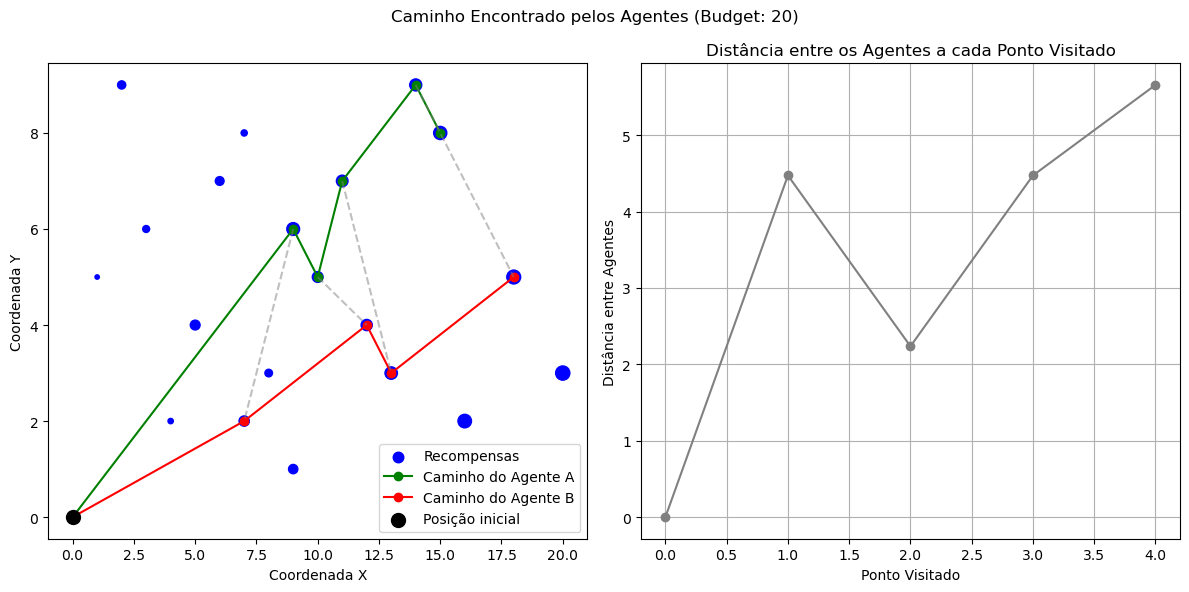

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from deap import tools

# Função para calcular a distância entre dois pontos
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Exemplo de função para visualizar o melhor caminho com a restrição de budget e a distância entre os agentes
def plot_best_path_with_budget_and_distances(best_individual: list, rewards: np.ndarray, budget: float):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plota todos os pontos de recompensa
    reward_points = rewards[:, :2]
    reward_values = rewards[:, 2]

    ax1.scatter(reward_points[:, 0], reward_points[:, 1], c='blue', s=reward_values, label='Recompensas')

    # Plota o caminho do agente A, respeitando o budget
    path_A = best_individual[0]
    path_A_coords = reward_points[path_A]
    
    total_distance_A = 0
    valid_coords_A = [np.array([0, 0])]  # Começa na origem [0, 0]

    # Calcula o caminho respeitando o budget
    for i in range(len(path_A_coords)):
        next_point = path_A_coords[i]
        distance = calculate_distance(valid_coords_A[-1], next_point)
        if total_distance_A + distance <= budget:
            total_distance_A += distance
            valid_coords_A.append(next_point)
        else:
            break

    valid_coords_A = np.array(valid_coords_A)
    ax1.plot(valid_coords_A[:, 0], valid_coords_A[:, 1], '-o', color='green', label='Caminho do Agente A')

    # Plota o caminho do agente B, respeitando o budget
    path_B = best_individual[1]
    path_B_coords = reward_points[path_B]

    total_distance_B = 0
    valid_coords_B = [np.array([0, 0])]  # Começa na origem [0, 0]

    # Calcula o caminho respeitando o budget
    for i in range(len(path_B_coords)):
        next_point = path_B_coords[i]
        distance = calculate_distance(valid_coords_B[-1], next_point)
        if total_distance_B + distance <= budget:
            total_distance_B += distance
            valid_coords_B.append(next_point)
        else:
            break

    valid_coords_B = np.array(valid_coords_B)
    ax1.plot(valid_coords_B[:, 0], valid_coords_B[:, 1], '-o', color='red', label='Caminho do Agente B')

    # Plota as distâncias entre os agentes
    distances_between_agents = []
    min_len = min(len(valid_coords_A), len(valid_coords_B))
    for i in range(min_len):
        point_A = valid_coords_A[i]
        point_B = valid_coords_B[i]
        distance_between_agents = calculate_distance(point_A, point_B)
        distances_between_agents.append(distance_between_agents)
        ax1.plot([point_A[0], point_B[0]], [point_A[1], point_B[1]], color='gray', linestyle='--', alpha=0.5)

    # Plotando as distâncias entre os agentes ao longo do caminho
    ax2.plot(range(len(distances_between_agents)), distances_between_agents, color='gray', marker='o')
    ax2.set_xlabel('Ponto Visitado')
    ax2.set_ylabel('Distância entre Agentes')
    ax2.set_title('Distância entre os Agentes a cada Ponto Visitado')

    # Adiciona a posição inicial em (0, 0)
    ax1.scatter(0, 0, c='black', s=100, label='Posição inicial', zorder=5)

    # Labels e legenda
    ax1.set_xlabel('Coordenada X')
    ax1.set_ylabel('Coordenada Y')
    ax1.legend()

    plt.suptitle(f'Caminho Encontrado pelos Agentes (Budget: {budget})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemplo de uso ao final da execução do algoritmo
best_individual = tools.selBest(population, 1)[0]
plot_best_path_with_budget_and_distances(best_individual, rewards, BUDGET)
